# Part 1: Data Collection for Text Comparison and Clustering

## Data Collection

In [207]:
import wikipedia
import requests
from bs4 import BeautifulSoup
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.parse import quote
from typing import List, Dict, Tuple
import requests
import json
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
import requests
from bs4 import BeautifulSoup
import os
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from tqdm import tqdm
import wikipediaapi


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC.PACK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC.PACK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [218]:
categories = [("Astronauts", "dbo:Astronaut"), ("Chefs", "dbo:Chef")]
max_biographies_per_category = 100
max_biographies = 100
output_dir =  "output"



**1.1 Extracting Biographies "ENGLISH"**

In [243]:
import requests
import time
from bs4 import BeautifulSoup
from SPARQLWrapper import SPARQLWrapper, JSON
from typing import List, Dict

def get_biography_from_wikipedia(wiki_url: str) -> str:
    """
    Given a Wikipedia URL, retrieves the biography text.
    """
    try:
        response = requests.get(wiki_url)
        response.raise_for_status()  # Raise HTTPError for bad responses
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            intro_paragraphs = soup.find_all('p', limit=3)
            intro_text = " ".join([para.text.strip() for para in intro_paragraphs])
            return intro_text
    except requests.RequestException as e:
        pass  # Ignore request errors silently
    except Exception as e:
        pass  # Ignore all other exceptions silently
    return ""

def get_biographies_en(category: str, rdf_type: str, max_biographies: int) -> List[Dict[str, str]]:
    biographies = []
    unique_names = set()
    
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    offset = 0
    while len(biographies) < max_biographies:
        query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            
            SELECT DISTINCT ?page ?name
            WHERE {{
                ?page rdf:type {rdf_type} .
                ?page rdfs:label ?name .
                FILTER (lang(?name) = 'en')
            }}
            LIMIT {max_biographies}
            OFFSET {offset}
        """
        
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        
        try:
            results = sparql.query().convert()
            if not results["results"]["bindings"]:
                break
            
            for result in results["results"]["bindings"]:
                if len(biographies) >= max_biographies:
                    break
                
                name = result["name"]["value"]
                if name in unique_names:
                    continue
                unique_names.add(name)
                
                dbpedia_url = result["page"]["value"]
                wiki_title = dbpedia_url.split("/")[-1]
                wiki_url = f"https://en.wikipedia.org/wiki/{wiki_title}"
                
                intro_text = get_biography_from_wikipedia(wiki_url)
                
                if intro_text:
                    biographies.append({"name": name, "biography": intro_text})
        
        except Exception:
            break
        
        offset += max_biographies  # Move to the next batch
    
    return biographies[:max_biographies]  # Return only up to max_biographies




Astronaut biographies: 100
Chef biographies: 100


**1.2 Extracting Knowledge Graph Facts "ENGLISH"**

In [244]:
def extract_kg_facts(person_names: List[str]) -> Dict[str, List[Dict]]:
    """
    Extract KG Graph facts (RDF triples) for the specified people from DBpedia.

    Args:
        person_names (List[str]): List of person names.

    Returns:
        Dict[str, List[Dict]]: A dictionary containing KG Graph facts for each person.
    """
    kg_facts = {}

    for person_name in person_names:
        kg_facts[person_name] = []

        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        encoded_person_name = quote(person_name.replace(" ", "_"))
        query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT DISTINCT ?predicate ?object
            WHERE {{
                <http://dbpedia.org/resource/{encoded_person_name}> ?predicate ?object.
            }}
        """

        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)

        results = sparql.query().convert()

        for result in results["results"]["bindings"]:
            predicate = result["predicate"]["value"]
            obj = result["object"]["value"]
            kg_facts[person_name].append({"predicate": predicate, "object": obj})

    return kg_facts



   **Storing Data**
   - Each biography will also be saved in a separate text file named **`person_category.txt`**.

In [245]:
def save_biographies_and_facts(data: Dict[str, Dict[str, List[Dict]]], output_dir: str) -> pd.DataFrame:
    """
    Save biographies and KG facts to text files and JSON file respectively.

    Args:
        data (Dict[str, Dict[str, List[Dict]]]): A dictionary containing biographies and KG facts for each category.
        output_dir (str): Directory to save the output files.

    Returns:
        pd.DataFrame: DataFrame containing biographies and categories.
    """
    os.makedirs(output_dir, exist_ok=True)

    for category, category_data in data.items():
        biographies = category_data["biographies"]
        kg_facts = category_data["kg_facts"]

        # Save biographies to text files
        for bio in biographies:
            person_name = bio["name"]
            biography_text = bio["biography"]
            # Generate safe file name
            safe_person_name = "".join([c if c.isalnum() else "_" for c in person_name])
            safe_person_name = safe_person_name[:50]  # Truncate if longer than 50 characters
            filename = f"{safe_person_name}_{category}.txt"
            
            with open(os.path.join(output_dir, filename), 'w', encoding='utf-8') as f:
                f.write(biography_text)

        # Save KG facts to JSON
        kg_facts_path = os.path.join(output_dir, f"{category}_kg_facts.json")
        with open(kg_facts_path, 'w', encoding='utf-8') as f:
            json.dump(kg_facts, f, indent=4, ensure_ascii=False)
    
    print("Biographies and KG facts saved successfully.")

In [250]:
import os
import json
import pandas as pd

def save_biographies_and_facts(data: Dict[str, Dict[str, List[Dict]]], output_dir: str) -> pd.DataFrame:
    """
    Save biographies and KG facts to text files and JSON file respectively.

    Args:
        data (Dict[str, Dict[str, List[Dict]]]): A dictionary containing biographies and KG facts for each category.
        output_dir (str): Directory to save the output files.

    Returns:
        pd.DataFrame: DataFrame containing biographies and categories.
    """
    os.makedirs(output_dir, exist_ok=True)

    try:
        for category, category_data in data.items():
            biographies = category_data["biographies"]
            kg_facts = category_data["kg_facts"]

            # Save biographies to text files
            for bio in biographies:
                person_name = bio["name"]
                biography_text = bio["biography"]
                # Generate safe file name
                safe_person_name = "".join([c if c.isalnum() else "_" for c in person_name])
                safe_person_name = safe_person_name[:50]  # Truncate if longer than 50 characters
                filename = f"{safe_person_name}_{category}.txt"
                
                with open(os.path.join(output_dir, filename), 'w', encoding='utf-8') as f:
                    f.write(biography_text)

            # Save KG facts to JSON
            kg_facts_path = os.path.join(output_dir, f"{category}_kg_facts.json")
            with open(kg_facts_path, 'w', encoding='utf-8') as f:
                json.dump(kg_facts, f, indent=4, ensure_ascii=False)
        
        print("Biographies and KG facts saved successfully.")
    
    except IOError as e:
        print(f"Error writing file: {e}")
    
    except Exception as e:
        print(f"Unexpected error: {e}")

# Example usage
# Assuming `data` contains biographies and KG facts in the required format
# and `output_dir` is the directory path where you want to save the files
# save_biographies_and_facts(data, output_dir)


In [253]:

def save_biographies_and_facts(data: Dict[str, Dict[str, List[Dict]]], output_dir: str) -> None:
    """
    Save biographies and KG facts to text files and JSON file respectively.

    Args:
        data (Dict[str, Dict[str, List[Dict]]]): A dictionary containing biographies and KG facts for each category.
        output_dir (str): Directory to save the output files.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)

    for category, category_data in data.items():
            biographies = category_data["biographies"]
            kg_facts = category_data["kg_facts"]

            # Save biographies to text files
    for bio in biographies:
                person_name = bio["name"]
                biography_text = bio["biography"]
                # Generate safe file name
                safe_person_name = "".join([c if c.isalnum() else "_" for c in person_name])
                safe_person_name = safe_person_name[:50]  # Truncate if longer than 50 characters
                filename = f"{safe_person_name}_{category}.txt"
                
                with open(os.path.join(output_dir, filename), 'w', encoding='utf-8') as f:
                    f.write(biography_text)

            # Save KG facts to JSON
    kg_facts_path = os.path.join(output_dir, f"{category}_kg_facts.json")
    with open(kg_facts_path, 'w', encoding='utf-8') as f:
                json.dump(kg_facts, f, indent=4, ensure_ascii=False)
        
    print("Biographies and KG facts saved successfully.")

In [254]:
if __name__ == "__main__":
    categories = [
        ("Astronauts", "dbo:Astronaut"),
        ("Chefs", "dbo:Chef")
    ]
    
    max_biographies = 100
    output_dir = "./output"
    
    biographies_data = {}
    for category, rdf_type in categories:
        biographies = get_biographies_en(category, rdf_type, max_biographies)
        kg_facts = extract_kg_facts([bio["name"] for bio in biographies])
        biographies_data[category] = {"biographies": biographies, "kg_facts": kg_facts}
    
    save_biographies_and_facts(biographies_data, output_dir)

Biographies and KG facts saved successfully.


**1.2 Save biographies and knowledge facts "French"**
   - The knowledge graph facts will be stored in a JSON file, mapped back to each person.

In [164]:
import time

def get_biographies_en(category: str, rdf_type: str, max_biographies: int) -> List[Dict[str, str]]:
    """
    Retrieve biographies from Wikipedia for a specified category and RDF type in English.

    Args:
        category (str): The category name (e.g., "Astronauts", "Chefs").
        rdf_type (str): The RDF type of the category (e.g., "dbo:Astronaut", "dbo:Chef").
        max_biographies (int): Maximum number of biographies to collect.

    Returns:
        List[Dict[str, str]]: A list of dictionaries containing the person's name and biography.
    """
    biographies = []
    unique_names = set()
    retry_attempts = 3  # Number of retry attempts
    retry_delay = 5  # Seconds to wait before retrying

    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        
        SELECT DISTINCT ?page ?name
        WHERE {{
            ?page rdf:type {rdf_type} .
            ?page rdfs:label ?name .
            FILTER (lang(?name) = 'en')
        }}
        LIMIT {max_biographies}
    """
    
    for attempt in range(1, retry_attempts + 1):
        try:
            sparql.setQuery(query)
            sparql.setReturnFormat(JSON)
            
            results = sparql.query().convert()
            
            for result in results["results"]["bindings"]:
                name = result["name"]["value"]
                if name in unique_names:
                    continue
                unique_names.add(name)
                
                dbpedia_url = result["page"]["value"]
                wiki_title = dbpedia_url.split("/")[-1]
                wiki_url = f"https://en.wikipedia.org/wiki/{wiki_title}"
                
                try:
                    response = requests.get(wiki_url)
                    if response.status_code == 200:
                        soup = BeautifulSoup(response.text, "html.parser")
                        
                        # Extract introductory paragraphs
                        intro_paragraphs = soup.find_all('p', limit=3)
                        intro_text = " ".join([para.text.strip() for para in intro_paragraphs])
                        
                        if intro_text:
                            biographies.append({"name": name, "biography": intro_text})
                        else:
                            print(f"No introductory paragraphs found for {name}")
                    else:
                        print(f"Failed to retrieve page for {name}, status code: {response.status_code}")
                except Exception as e:
                    print(f"Failed to retrieve biography for {name}: {e}")
            
            print(f"Collected {len(biographies)} biographies for category {category}")
            return biographies
        
        except Exception as e:
            print(f"Attempt {attempt} failed: {e}")
            if attempt < retry_attempts:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
    
    print(f"Failed to collect biographies for category {category} after {retry_attempts} attempts.")
    return biographies


In [161]:
from typing import List, Dict
from bs4 import BeautifulSoup
import requests
from SPARQLWrapper import SPARQLWrapper, JSON

def get_biographies_fr(category: str, rdf_type: str, max_biographies: int) -> List[Dict[str, str]]:
    """
    Retrieve biographies from Wikipedia for a specified category and RDF type in French.

    Args:
        category (str): The category name (e.g., "Astronauts", "Chefs").
        rdf_type (str): The RDF type of the category (e.g., "dbo:Astronaut", "dbo:Chef").
        max_biographies (int): Maximum number of biographies to collect.

    Returns:
        List[Dict[str, str]]: A list of dictionaries containing the person's name and biography.
    """
    biographies = []
    unique_names = set()
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    query = f"""
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>
        
        SELECT DISTINCT ?page ?name ?wiki
        WHERE {{
            ?page rdf:type {rdf_type} .
            ?page rdfs:label ?name .
            ?page foaf:isPrimaryTopicOf ?wiki .
            FILTER (lang(?name) = 'fr')
        }}
        LIMIT {max_biographies}
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        results = sparql.query().convert()
        
        for result in results["results"]["bindings"]:
            name = result["name"]["value"]
            wiki_url = result["wiki"]["value"]
            
            if name in unique_names:
                continue
            unique_names.add(name)
            
            try:
                response = requests.get(wiki_url)
                if response.status_code == 200:
                    soup = BeautifulSoup(response.text, "html.parser")
                    
                    # Extract introductory paragraphs
                    intro_paragraphs = soup.find_all('p', limit=3)
                    intro_text = " ".join([para.text.strip() for para in intro_paragraphs])
                    
                    if intro_text:
                        biographies.append({"name": name, "biography": intro_text})
                    else:
                        print(f"No introductory paragraphs found for {name}")
                else:
                    print(f"Failed to retrieve page for {name}, status code: {response.status_code}")
                
                if len(biographies) >= max_biographies:
                    break  # Exit loop if we've collected enough biographies
            except Exception as e:
                print(f"Failed to retrieve biography for {name}: {e}")
    
    except Exception as e:
        print(f"SPARQL query failed: {e}")
    
    print(f"Collected {len(biographies)} biographies for category {category}")
    return biographies 


In [165]:
astronaut_biographies = get_biographies_fr("Astronautes", "dbo:Astronaut", 100)
chef_biographies = get_biographies_fr("Chefs", "dbo:Chef", 100)

SPARQL query failed: HTTP Error 503: Service Temporarily Unavailable
Collected 0 biographies for category Astronautes
Collected 100 biographies for category Chefs


In [117]:
print(astronaut_biographies)
print(chef_biographies)

[{'name': 'Cai Xuzhe', 'biography': " Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is a Chinese People's Liberation Army Astronaut Corps (PLAAC) taikonaut selected as part of the Shenzhou program. Cai was born in Shenzhou, Hengshui, Hebei province in 1976.[2] His grandparents come from a scholarly family, teaching in the downtown county and village, respectively, and were veteran party members before the founding of the People's Republic of China.[3]  His third uncle was a soldier.[3] Cai graduated from the Baoding Branch of the Changchun Flight Academy of the Air Force.[3]  He served as a fighter pilot in the People's Liberation Army Air Force, and was subsequently selected to be an astronaut in 2010.[4] His name was revealed as part of Group 2 in 2011.[5]"}, {'name': 'Carl E. Walz', 'biography': " Carl Erwin Walz (born 6 September 1955) is a retired NASA astronaut currently working for Orbital Sciences Corporation's Advanced Programs Group as vice president for Human Space Flight Opera

**Extract knowledge facts "FRENCH"**

In [ ]:
def extract_kg_facts(person_names: List[str]) -> Dict[str, List[Dict]]:
    """
    Extract KG Graph facts (RDF triples) for the specified people from DBpedia.

    Args:
        person_names (List[str]): List of person names.

    Returns:
        Dict[str, List[Dict]]: A dictionary containing KG Graph facts for each person.
    """
    kg_facts = {}

    for person_name in person_names:
        kg_facts[person_name] = []

        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        encoded_person_name = quote(person_name.replace(" ", "_"))
        query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT DISTINCT ?predicate ?object
            WHERE {{
                <http://dbpedia.org/resource/{encoded_person_name}> ?predicate ?object.
            }}
        """

        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)

        results = sparql.query().convert()

        for result in results["results"]["bindings"]:
            predicate = result["predicate"]["value"]
            obj = result["object"]["value"]
            kg_facts[person_name].append({"predicate": predicate, "object": obj})

    return kg_facts


**Bibliographies will be stored as a dataframe**

In [118]:
def store_biographies_as_dataframe(biographies_data: Dict[str, Dict[str, List[Dict[str, str]]]]) -> pd.DataFrame:
    """
    Store each biography along with its category in a Pandas DataFrame.

    Args:
        biographies_data (Dict[str, Dict[str, List[Dict[str, str]]]]): A dictionary containing biographies and KG facts for each category.

    Returns:
        pd.DataFrame: DataFrame containing biographies and categories.
    """
    biographies_list = []
    categories_list = []

    for category, data in biographies_data.items():
        biographies = data["biographies"]
        for bio in biographies:
            biographies_list.append(bio["biography"])
            categories_list.append(category)


    df = pd.DataFrame({"Biography": biographies_list, "Category": categories_list})
    return df


In [120]:
#  store biographies in a DataFrame
df_english = store_biographies_as_dataframe(biographies_data)

In [121]:
df_english

Biography    Category
0     Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts
1     Carl Erwin Walz (born 6 September 1955) is a ...  Astronauts
2    Carl Joseph Meade (born November 16, 1950) is ...  Astronauts
3     Carlos Ismael Noriega (born 8 October 1959) i...  Astronauts
4    Pyotr Valerievich Dubrov (Russian: Пётр Валерь...  Astronauts
..                                                 ...         ...
194  Julien Royer (born 1 September 1982) is a Fren...       Chefs
195   Juliet Corson (January 14, 1841 – June 18, 18...       Chefs
196  Beverly Kim is a James Beard Award-winning che...       Chefs
197  Patrick O'Connell (born October 9, 1945) is an...       Chefs
198   Paul Ainsworth (born 1979) is an English chef...       Chefs

[199 rows x 2 columns]

## Data Analysis: Text Data


### Preprocessing Function (`preprocess_text`):
1. Normalize each sentence to lowercase.
2. Remove stopwords .
3. Join the remaining tokens back into sentences.

In [122]:

nlp = spacy.load("en_core_web_sm")


In [123]:
df_english

Biography    Category
0     Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts
1     Carl Erwin Walz (born 6 September 1955) is a ...  Astronauts
2    Carl Joseph Meade (born November 16, 1950) is ...  Astronauts
3     Carlos Ismael Noriega (born 8 October 1959) i...  Astronauts
4    Pyotr Valerievich Dubrov (Russian: Пётр Валерь...  Astronauts
..                                                 ...         ...
194  Julien Royer (born 1 September 1982) is a Fren...       Chefs
195   Juliet Corson (January 14, 1841 – June 18, 18...       Chefs
196  Beverly Kim is a James Beard Award-winning che...       Chefs
197  Patrick O'Connell (born October 9, 1945) is an...       Chefs
198   Paul Ainsworth (born 1979) is an English chef...       Chefs

[199 rows x 2 columns]

In [124]:

biographies_df = df_english


def preprocess_text(text):
    doc = nlp(text)  # Tokenize
    sentences = [sent.text for sent in doc.sents]  # Segment into sentences
    return sentences


biographies_df['preprocessed_sentences'] = biographies_df['Biography'].apply(preprocess_text)

def preprocess_tokens(text):
    doc = nlp(text.lower())  # Tokenize and normalize to lowercase
    # Remove stopwords, punctuation, and non-alphabetic tokens
    preprocessed_text = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return preprocessed_text

biographies_df['preprocessed_text'] = biographies_df['Biography'].apply(preprocess_tokens)

In [51]:
df_english.head()

Biography    Category  \
0   Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts   
1   Carl Erwin Walz (born 6 September 1955) is a ...  Astronauts   
2  Carl Joseph Meade (born November 16, 1950) is ...  Astronauts   
3   Carlos Ismael Noriega (born 8 October 1959) i...  Astronauts   
4  Pyotr Valerievich Dubrov (Russian: Пётр Валерь...  Astronauts   

                              preprocessed_sentences  \
0  [ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...   
1  [ Carl Erwin Walz (born 6 September 1955) is a...   
2  [Carl Joseph Meade (born November 16, 1950) is...   
3  [ Carlos Ismael Noriega (born 8 October 1959) ...   
4  [Pyotr Valerievich Dubrov (Russian: Пётр Валер...   

                                   preprocessed_text  
0  [cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...  
1  [carl, erwin, walz, bear, september, retire, n...  
2  [carl, joseph, meade, bear, november, nasa, as...  
3  [carlos, ismael, noriega, bear, october, peruv...  
4  [pyotr, valerievich, dubrov, russian, пётр, ва...

In [125]:
def get_all_tokens(df, category):
    tokens = []
    for series in df[df["Category"] == category]['preprocessed_text']:
        for t in series:
            tokens.append(t)
    return tokens

In [126]:
CATEGORY1 = 'Astronauts'
CATEGORY2 = 'Chefs'

In [128]:
tokens1 = get_all_tokens(df_english, CATEGORY1)
tokens2 = get_all_tokens(df_english, CATEGORY2)

- Vocabulary: 50 most frequent words and word cloud for each category.

In [129]:
import collections
def make_wordcloud(tokens, n_words):
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

- wordcloud for the category : 'Astronauts'

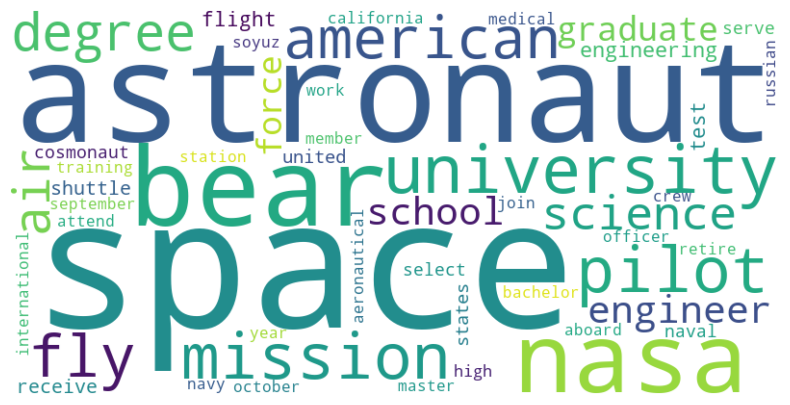

In [130]:
make_wordcloud(tokens1, 50)

- wordcloud for the category : 'Chefs'

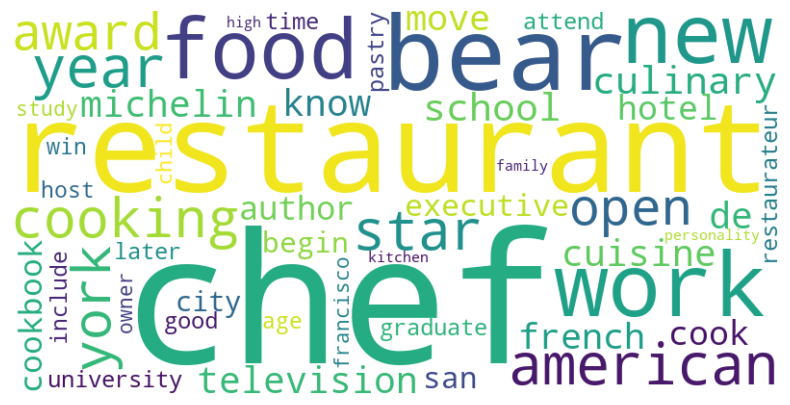

In [131]:
make_wordcloud(tokens2, 50)

In [132]:
biographies_df['num_sentences'] = biographies_df['preprocessed_sentences'].apply(len)

In [133]:
df_english

Biography    Category  \
0     Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts   
1     Carl Erwin Walz (born 6 September 1955) is a ...  Astronauts   
2    Carl Joseph Meade (born November 16, 1950) is ...  Astronauts   
3     Carlos Ismael Noriega (born 8 October 1959) i...  Astronauts   
4    Pyotr Valerievich Dubrov (Russian: Пётр Валерь...  Astronauts   
..                                                 ...         ...   
194  Julien Royer (born 1 September 1982) is a Fren...       Chefs   
195   Juliet Corson (January 14, 1841 – June 18, 18...       Chefs   
196  Beverly Kim is a James Beard Award-winning che...       Chefs   
197  Patrick O'Connell (born October 9, 1945) is an...       Chefs   
198   Paul Ainsworth (born 1979) is an English chef...       Chefs   

                                preprocessed_sentences  \
0    [ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...   
1    [ Carl Erwin Walz (born 6 September 1955) is a...   
2    [Carl Joseph Meade (born November 16, 1950) is...   
3    [ Carlos Ismael Noriega (born 8 October 1959) ...   
4    [Pyotr Valerievich Dubrov (Russian: Пётр Валер...   
..                                                 ...   
194  [Julien Royer (born 1 September 1982) is a Fre...   
195  [ Juliet Corson (January 14, 1841 – June 18, 1...   
196  [Beverly Kim is a James Beard Award-winning ch...   
197  [Patrick O'Connell (born October 9, 1945) is a...   
198  [ Paul Ainsworth (born 1979) is an English che...   

                                     preprocessed_text  num_sentences  
0    [cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...              5  
1    [carl, erwin, walz, bear, september, retire, n...              6  
2    [carl, joseph, meade, bear, november, nasa, as...             10  
3    [carlos, ismael, noriega, bear, october, peruv...             10  
4    [pyotr, valerievich, dubrov, russian, пётр, ва...              6  
..                                                 ...            ...  
194  [julien, royer, bear, september, french, chef,...              9  
195  [juliet, corson, january, june, leader, cooker...              5  
196  [beverly, kim, james, beard, award, win, chef,...              5  
197  [patrick, bear, october, american, chef, propr...              2  
198  [paul, ainsworth, bear, english, chef, southam...              7  

[199 rows x 5 columns]

- sum of sentences in each category

In [134]:
biographies_df.groupby('Category')['num_sentences'].sum()

Category
Astronauts    650
Chefs         702
Name: num_sentences, dtype: int64

- Min/max/avg number of sentences per each category

In [135]:
min_sentences = biographies_df.groupby('Category')['num_sentences'].min()
avg_sentences = biographies_df.groupby('Category')['num_sentences'].mean()
max_sentences = biographies_df.groupby('Category')['num_sentences'].max()

print("Minimum Number of Sentences per Category:\n", min_sentences)
print("\nAverage Number of Sentences per Category:\n", avg_sentences)
print("\nMaximum Number of Sentences per Category:\n", max_sentences)


Minimum Number of Sentences per Category:
 Category
Astronauts    1
Chefs         1
Name: num_sentences, dtype: int64

Average Number of Sentences per Category:
 Category
Astronauts    6.500000
Chefs         7.090909
Name: num_sentences, dtype: float64

Maximum Number of Sentences per Category:
 Category
Astronauts    19
Chefs         17
Name: num_sentences, dtype: int64


- Box plots for both categories

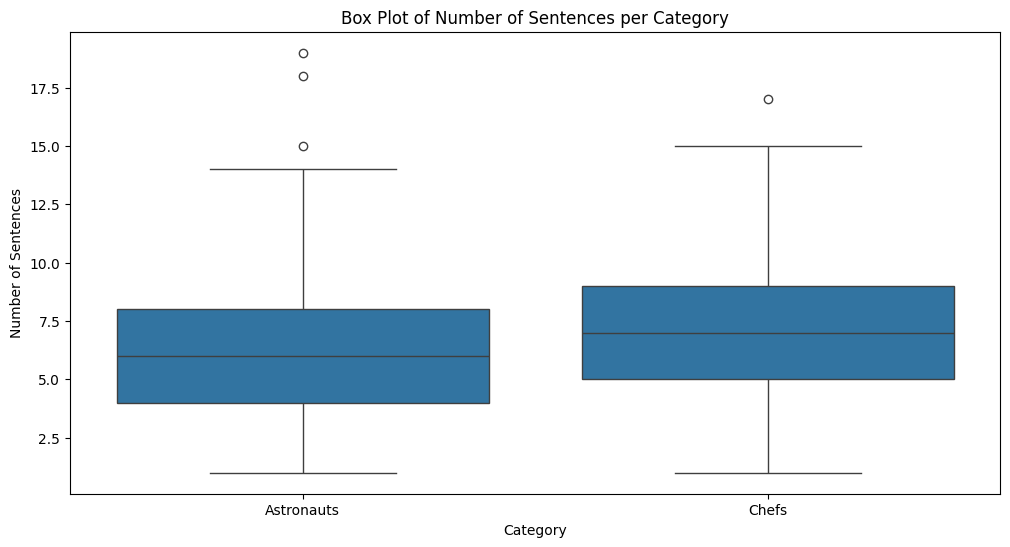

In [136]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=biographies_df, x='Category', y='num_sentences')
plt.title('Box Plot of Number of Sentences per Category')
plt.xlabel('Category')
plt.ylabel('Number of Sentences')
plt.show()


- Box Plot of Number of Sentences for 'Astronauts'
- Box Plot of Number of Sentences for 'Chefs'

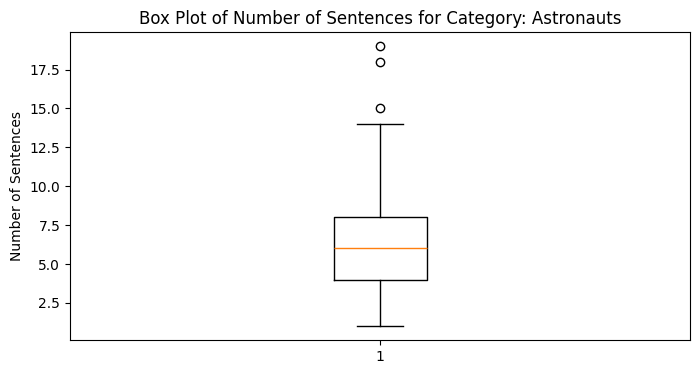

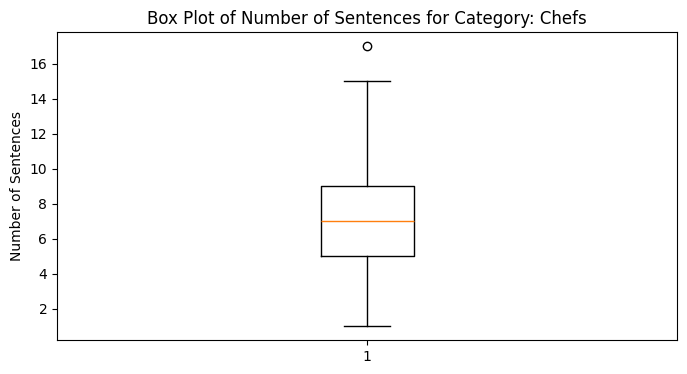

In [137]:
categories = biographies_df['Category'].unique()

for category in categories:
    plt.figure(figsize=(8, 4)) 
    
    data = biographies_df[biographies_df['Category'] == category]['num_sentences']

    plt.boxplot(data)

    plt.title(f'Box Plot of Number of Sentences for Category: {category}')
    plt.ylabel('Number of Sentences')

    plt.show()


- Histogram of Number of Sentences for both categories

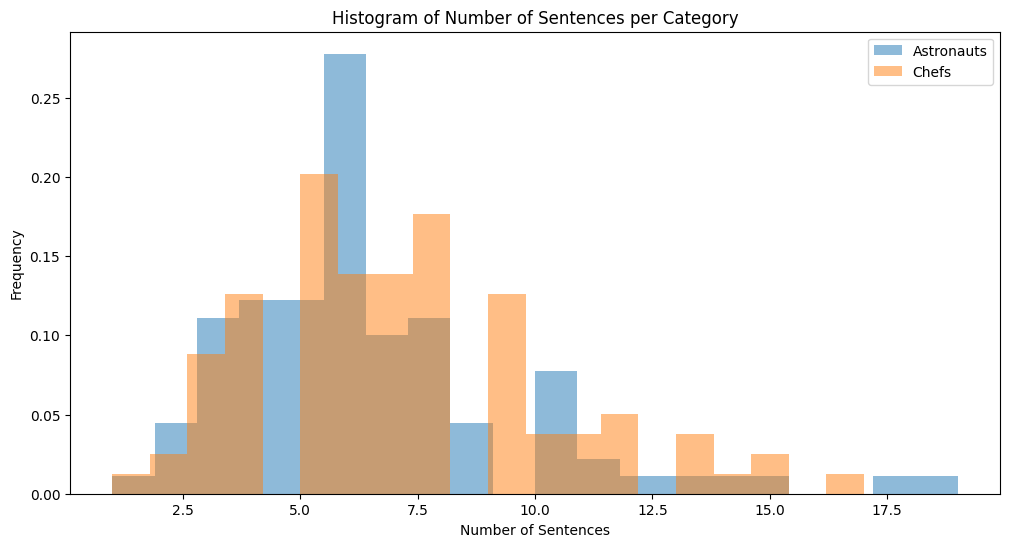

In [138]:
plt.figure(figsize=(12, 6))

#for each category
for category in biographies_df['Category'].unique():
    data = biographies_df[biographies_df['Category'] == category]['num_sentences']
    plt.hist(data, bins=20, alpha=0.5, label=category, density=True)

plt.title('Histogram of Number of Sentences per Category')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.legend()
plt.show()


 - Histogram of Number of Sentences for 'Astronauts'
 - Histogram of Number of Sentences for 'Chefs'

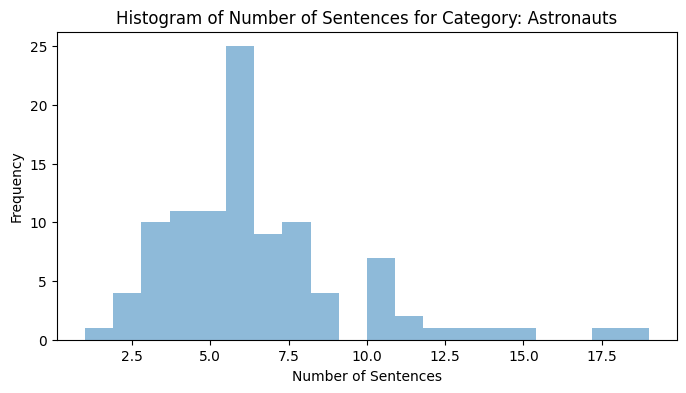

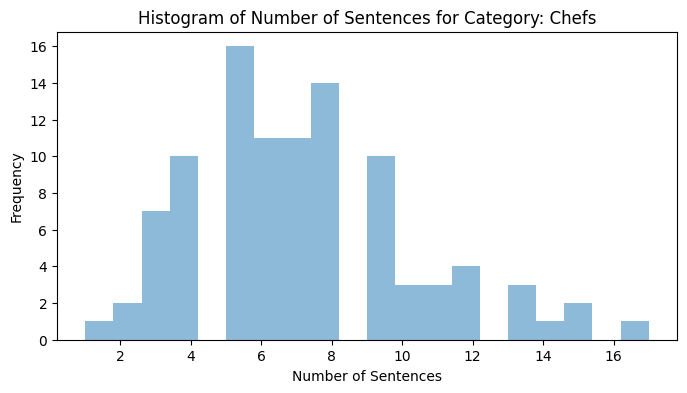

In [139]:
categories = biographies_df['Category'].unique()
for category in categories:
    plt.figure(figsize=(8, 4))  
    data = biographies_df[biographies_df['Category'] == category]['num_sentences']
    plt.hist(data, bins=20, alpha=0.5)
    plt.title(f'Histogram of Number of Sentences for Category: {category}')
    plt.xlabel('Number of Sentences')
    plt.ylabel('Frequency')
    plt.show()


In [140]:
def collect_bigrams(tokens):
    bigrams = nltk.bigrams(tokens)
    occurences = {}
    for bigram in bigrams:
        if occurences.get(bigram):
            occurences[bigram] += 1
        else:
            occurences[bigram] = 1
    return occurences

In [141]:
bigrams1 = collect_bigrams(tokens1)
bigrams2 = collect_bigrams(tokens2)

In [142]:
biographies_df['bi_grams'] = biographies_df['preprocessed_text'].apply(lambda x: list(nltk.bigrams(x)))

# Count occurrences of each bigram
bi_gram_counts = biographies_df['bi_grams'].apply(Counter)

print(bi_gram_counts)

0      {('cai', 'xuzhe'): 1, ('xuzhe', 'chinese'): 1,...
1      {('carl', 'erwin'): 1, ('erwin', 'walz'): 1, (...
2      {('carl', 'joseph'): 1, ('joseph', 'meade'): 1...
3      {('carlos', 'ismael'): 1, ('ismael', 'noriega'...
4      {('pyotr', 'valerievich'): 1, ('valerievich', ...
                             ...                        
194    {('julien', 'royer'): 1, ('royer', 'bear'): 2,...
195    {('juliet', 'corson'): 1, ('corson', 'january'...
196    {('beverly', 'kim'): 1, ('kim', 'james'): 1, (...
197    {('patrick', 'bear'): 1, ('bear', 'october'): ...
198    {('paul', 'ainsworth'): 2, ('ainsworth', 'bear...
Name: bi_grams, Length: 199, dtype: object


In [143]:
biographies_df

Biography    Category  \
0     Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts   
1     Carl Erwin Walz (born 6 September 1955) is a ...  Astronauts   
2    Carl Joseph Meade (born November 16, 1950) is ...  Astronauts   
3     Carlos Ismael Noriega (born 8 October 1959) i...  Astronauts   
4    Pyotr Valerievich Dubrov (Russian: Пётр Валерь...  Astronauts   
..                                                 ...         ...   
194  Julien Royer (born 1 September 1982) is a Fren...       Chefs   
195   Juliet Corson (January 14, 1841 – June 18, 18...       Chefs   
196  Beverly Kim is a James Beard Award-winning che...       Chefs   
197  Patrick O'Connell (born October 9, 1945) is an...       Chefs   
198   Paul Ainsworth (born 1979) is an English chef...       Chefs   

                                preprocessed_sentences  \
0    [ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...   
1    [ Carl Erwin Walz (born 6 September 1955) is a...   
2    [Carl Joseph Meade (born November 16, 1950) is...   
3    [ Carlos Ismael Noriega (born 8 October 1959) ...   
4    [Pyotr Valerievich Dubrov (Russian: Пётр Валер...   
..                                                 ...   
194  [Julien Royer (born 1 September 1982) is a Fre...   
195  [ Juliet Corson (January 14, 1841 – June 18, 1...   
196  [Beverly Kim is a James Beard Award-winning ch...   
197  [Patrick O'Connell (born October 9, 1945) is a...   
198  [ Paul Ainsworth (born 1979) is an English che...   

                                     preprocessed_text  num_sentences  \
0    [cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...              5   
1    [carl, erwin, walz, bear, september, retire, n...              6   
2    [carl, joseph, meade, bear, november, nasa, as...             10   
3    [carlos, ismael, noriega, bear, october, peruv...             10   
4    [pyotr, valerievich, dubrov, russian, пётр, ва...              6   
..                                                 ...            ...   
194  [julien, royer, bear, september, french, chef,...              9   
195  [juliet, corson, january, june, leader, cooker...              5   
196  [beverly, kim, james, beard, award, win, chef,...              5   
197  [patrick, bear, october, american, chef, propr...              2   
198  [paul, ainsworth, bear, english, chef, southam...              7   

                                              bi_grams  
0    [(cai, xuzhe), (xuzhe, chinese), (chinese, 蔡旭哲...  
1    [(carl, erwin), (erwin, walz), (walz, bear), (...  
2    [(carl, joseph), (joseph, meade), (meade, bear...  
3    [(carlos, ismael), (ismael, noriega), (noriega...  
4    [(pyotr, valerievich), (valerievich, dubrov), ...  
..                                                 ...  
194  [(julien, royer), (royer, bear), (bear, septem...  
195  [(juliet, corson), (corson, january), (january...  
196  [(beverly, kim), (kim, james), (james, beard),...  
197  [(patrick, bear), (bear, october), (october, a...  
198  [(paul, ainsworth), (ainsworth, bear), (bear, ...  

[199 rows x 6 columns]

- bi_gram counts for each category

In [144]:
bi_gram_counts

0      {('cai', 'xuzhe'): 1, ('xuzhe', 'chinese'): 1,...
1      {('carl', 'erwin'): 1, ('erwin', 'walz'): 1, (...
2      {('carl', 'joseph'): 1, ('joseph', 'meade'): 1...
3      {('carlos', 'ismael'): 1, ('ismael', 'noriega'...
4      {('pyotr', 'valerievich'): 1, ('valerievich', ...
                             ...                        
194    {('julien', 'royer'): 1, ('royer', 'bear'): 2,...
195    {('juliet', 'corson'): 1, ('corson', 'january'...
196    {('beverly', 'kim'): 1, ('kim', 'james'): 1, (...
197    {('patrick', 'bear'): 1, ('bear', 'october'): ...
198    {('paul', 'ainsworth'): 2, ('ainsworth', 'bear...
Name: bi_grams, Length: 199, dtype: object

- min/max/avg number of bi-gram occurrences per sentence per category.

In [145]:
min_per_category = biographies_df.groupby('Category')['bi_grams'].apply(lambda x: np.min([len(bi_gram) for bi_gram in x]))
max_per_category = biographies_df.groupby('Category')['bi_grams'].apply(lambda x: np.max([len(bi_gram) for bi_gram in x]))
avg_per_category = biographies_df.groupby('Category')['bi_grams'].apply(lambda x: np.mean([len(bi_gram) for bi_gram in x]))

print("\nMin number of bi-gram occurrences per sentence per category:")
print(min_per_category)

print("\nMax number of bi-gram occurrences per sentence per category:")
print(max_per_category)

print("\nAverage number of bi-gram occurrences per sentence per category:")
print(avg_per_category)



Min number of bi-gram occurrences per sentence per category:
Category
Astronauts    13
Chefs         27
Name: bi_grams, dtype: int32

Max number of bi-gram occurrences per sentence per category:
Category
Astronauts    202
Chefs         200
Name: bi_grams, dtype: int32

Average number of bi-gram occurrences per sentence per category:
Category
Astronauts    69.780000
Chefs         75.161616
Name: bi_grams, dtype: float64


In [146]:


def compute_top_properties(kg_facts):
    all_properties = []
    for person, facts in kg_facts.items():
        properties = [fact['predicate'] for fact in facts]
        all_properties.extend(properties)
    
    # Count occurrences of each property
    property_counts = Counter(all_properties)
    
    # top 50 properties
    top_properties = property_counts.most_common(50)
    
    return top_properties

# Example usage:
# Assuming biographies_data contains the extracted data with RDF properties
for category, data in biographies_data.items():
    kg_facts = data['kg_facts']
    top_properties = compute_top_properties(kg_facts)
    
    print(f"Top 50 RDF Properties for Category: {category}")
    for prop, count in top_properties:
        print(f"Property: {prop}, Count: {count}")
    print("\n")


Top 50 RDF Properties for Category: Astronauts
Property: http://dbpedia.org/ontology/wikiPageWikiLink, Count: 7743
Property: http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Count: 3487
Property: http://www.w3.org/2002/07/owl#sameAs, Count: 2423
Property: http://purl.org/dc/terms/subject, Count: 1379
Property: http://dbpedia.org/property/wikiPageUsesTemplate, Count: 1132
Property: http://www.w3.org/2000/01/rdf-schema#label, Count: 1122
Property: http://www.w3.org/2000/01/rdf-schema#comment, Count: 1120
Property: http://dbpedia.org/ontology/abstract, Count: 1120
Property: http://xmlns.com/foaf/0.1/depiction, Count: 513
Property: http://dbpedia.org/ontology/wikiPageExternalLink, Count: 290
Property: http://dbpedia.org/ontology/mission, Count: 199
Property: http://dbpedia.org/ontology/birthPlace, Count: 131
Property: http://dbpedia.org/property/type, Count: 129
Property: http://dbpedia.org/property/mission, Count: 125
Property: http://dbpedia.org/property/occupation, Count: 122
Property: 

In [149]:
def compute_top_properties(kg_facts):
    """ Computes the top properties from the knowledge graph facts """
    property_counts = {}
    
    for fact in kg_facts:
        property = fact['property']  # Assuming each fact has a 'property' key
        
        if property in property_counts:
            property_counts[property] += 1
        else:
            property_counts[property] = 1
    
    # Convert dictionary to sorted list of tuples
    sorted_properties = sorted(property_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_properties


In [151]:
def extract_last_part(uri):
    """ Extracts the last part of a URI or IRI """
    return uri.split('/')[-1].split('#')[-1]

def compute_top_properties(kg_facts):
    """ Computes the top properties from the knowledge graph facts """
    property_counts = {}
    
    for fact in kg_facts:
        property = fact['property']  # Assuming each fact has a 'property' key
        
        if property in property_counts:
            property_counts[property] += 1
        else:
            property_counts[property] = 1
    
    # Convert dictionary to sorted list of tuples
    sorted_properties = sorted(property_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_properties


def generate_property_cloud(top_properties, category):
    """ Generates a word cloud from the top properties """
    property_cloud_dict = {prop: count for prop, count in top_properties}
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(property_cloud_dict)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Property Cloud for Category: {category}")
    plt.show()


for category, data in biographies_data.items():
    kg_facts = data['kg_facts']
    top_properties = compute_top_properties(kg_facts)
    
    generate_property_cloud(top_properties, category)


TypeError: string indices must be integers, not 'str'

In [154]:
def compute_top_properties(kg_facts):
    """ Computes the top properties from the knowledge graph facts """
    property_counts = {}
    
    for fact in kg_facts:
        print(type(fact), fact)  # Print type and content of each 'fact'
        # property = fact['property']  # Assuming each fact has a 'property' key
        
        # Replace the above with appropriate handling based on actual structure
        
        if property in property_counts:
            property_counts[property] += 1
        else:
            property_counts[property] = 1
    
    sorted_properties = sorted(property_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_properties


In [155]:
print(kg_facts)

{'Cai Xuzhe': [{'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://www.w3.org/2002/07/owl#Thing'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://xmlns.com/foaf/0.1/Person'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://dbpedia.org/ontology/Person'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#NaturalPerson'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://www.wikidata.org/entity/Q19088'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://www.wikidata.org/entity/Q215627'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://www.wikidata.org/entity/Q5'}, {'predicate': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'object': 'http://www.wikidata.org/entity/Q729'}, {'predicate': 'http://www.w3.org/1

In [77]:
df_shuffled = df.sample(frac=1).reset_index(drop=True) 

df_shuffled.head()

Biography    Category  \
0  Jordi Cruz Mas (born June 29, 1978 in Manresa,...       Chefs   
1  Elia Aboumrad (born in Mexico City, Mexico) is...       Chefs   
2   Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts   
3   Brewster Hopkinson Shaw Jr. (born May 16, 194...  Astronauts   
4   Robert William Flay (born December 10, 1964)[...       Chefs   

                              preprocessed_sentences  \
0  [Jordi Cruz Mas (born June 29, 1978 in Manresa...   
1  [Elia Aboumrad (born in Mexico City, Mexico) i...   
2  [ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...   
3  [ Brewster Hopkinson Shaw Jr. (born May 16, 19...   
4  [ Robert William Flay (born December 10, 1964)...   

                                   preprocessed_text  num_sentences  \
0  [jordi, cruz, mas, bear, june, manresa, barcel...              3   
1  [elia, aboumrad, bear, mexico, city, mexico, m...              8   
2  [cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...              5   
3  [brewster, hopkinson, shaw, jr, bear, retire, ...              4   
4  [robert, william, flay, bear, december, americ...              5   

                                            bi_grams  
0  [(jordi, cruz), (cruz, mas), (mas, bear), (bea...  
1  [(elia, aboumrad), (aboumrad, bear), (bear, me...  
2  [(cai, xuzhe), (xuzhe, chinese), (chinese, 蔡旭哲...  
3  [(brewster, hopkinson), (hopkinson, shaw), (sh...  
4  [(robert, william), (william, flay), (flay, be...

In [79]:
category_mapping = { "Astronauts": 0, "Chefs" : 1}

#applying to df
df_shuffled['numerical_category'] = df_shuffled['Category'].map(category_mapping)
df_shuffled.head()

Biography    Category  \
0  Jordi Cruz Mas (born June 29, 1978 in Manresa,...       Chefs   
1  Elia Aboumrad (born in Mexico City, Mexico) is...       Chefs   
2   Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...  Astronauts   
3   Brewster Hopkinson Shaw Jr. (born May 16, 194...  Astronauts   
4   Robert William Flay (born December 10, 1964)[...       Chefs   

                              preprocessed_sentences  \
0  [Jordi Cruz Mas (born June 29, 1978 in Manresa...   
1  [Elia Aboumrad (born in Mexico City, Mexico) i...   
2  [ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...   
3  [ Brewster Hopkinson Shaw Jr. (born May 16, 19...   
4  [ Robert William Flay (born December 10, 1964)...   

                                   preprocessed_text  num_sentences  \
0  [jordi, cruz, mas, bear, june, manresa, barcel...              3   
1  [elia, aboumrad, bear, mexico, city, mexico, m...              8   
2  [cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...              5   
3  [brewster, hopkinson, shaw, jr, bear, retire, ...              4   
4  [robert, william, flay, bear, december, americ...              5   

                                            bi_grams  numerical_category  
0  [(jordi, cruz), (cruz, mas), (mas, bear), (bea...                   1  
1  [(elia, aboumrad), (aboumrad, bear), (bear, me...                   1  
2  [(cai, xuzhe), (xuzhe, chinese), (chinese, 蔡旭哲...                   0  
3  [(brewster, hopkinson), (hopkinson, shaw), (sh...                   0  
4  [(robert, william), (william, flay), (flay, be...                   1

In [81]:

X = df_shuffled['preprocessed_text']
Y = df_shuffled['numerical_category']
X

0      [jordi, cruz, mas, bear, june, manresa, barcel...
1      [elia, aboumrad, bear, mexico, city, mexico, m...
2      [cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...
3      [brewster, hopkinson, shaw, jr, bear, retire, ...
4      [robert, william, flay, bear, december, americ...
                             ...                        
194    [thomas, hylton, bill, collin, july, march, br...
195    [roy, fare, bear, september, lebanese, bear, s...
196    [paul, desmond, scully, power, gose, fraes, be...
197    [beverly, kim, james, beard, award, win, chef,...
198    [carl, joseph, meade, bear, november, nasa, as...
Name: preprocessed_text, Length: 199, dtype: object

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

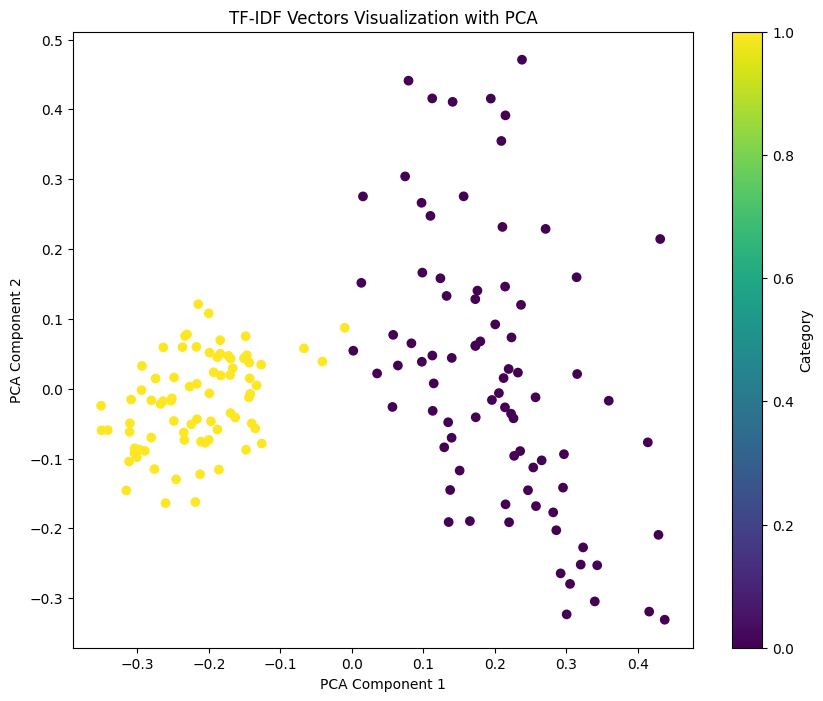

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# make the data in the correct format (list of strings)
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, use_idf=True, stop_words='english')

# Fit and transform the training data
X_train_vectors = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vectors = tfidf_vectorizer.transform(X_test)

# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Visualize the PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization with PCA')
plt.colorbar(label='Category')
plt.show()

In [92]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_vectors)
# list showing the cluster assigned to each instance
predicted_labels = km.labels_
clusters = predicted_labels.tolist()

In [93]:
train_data = {'text': X_train, 'category': y_train, 'cluster' : clusters}
df_train = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train

text  category  cluster
183  ['malcolm', 'scott', 'carpenter', 'october', '...         0        1
38   ['denis', 'vladimirovich', 'matveev', 'russian...         0        1
24   ['anne', 'kearney', 'american', 'chef', 'resta...         1        0
142  ['deniz', 'melissa', 'burnham', 'bear', 'octob...         0        1
141  ['roland', 'mesnier', 'july', 'august', 'frenc...         1        0
..                                                 ...       ...      ...
106  ['delia', 'ann', 'smith', 'ch', 'cbe', 'bear',...         1        0
14   ['david', 'saint', 'jacque', 'oc', 'oq', 'queb...         0        1
92   ['rahman', 'rock', 'harper', 'bear', 'december...         1        0
179  ['carson', 'gulley', 'june', 'november', 'head...         1        0
102  ['david', 'kinch', 'bear', 'april', 'american'...         1        0

[159 rows x 3 columns]

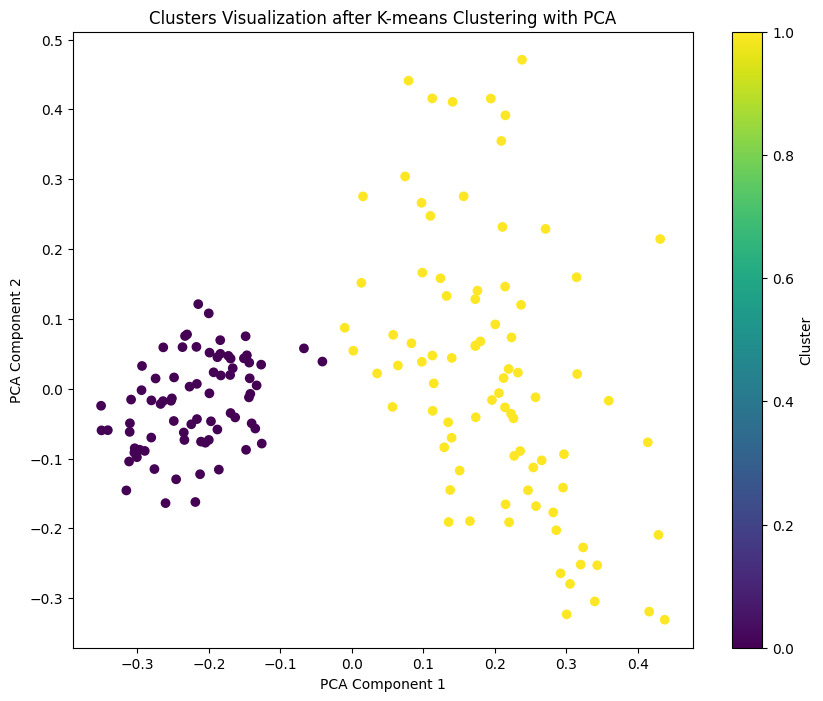

In [94]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Clusters plot
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.xlabel('PCA  1')
plt.ylabel('PCA  2')
plt.title('Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

In [97]:
#Supervised Metrics and Unsupervised Metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, predicted_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, predicted_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, predicted_labels))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train, predicted_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X_train_vectors, predicted_labels))

Homogeneity: 0.951
Completeness: 0.952
V-measure: 0.951
Adjusted Rand-Index: 0.975
Silhouette Coefficient: 0.043
